In [2]:
%load_ext autoreload
%autoreload 2

In [449]:
from gammapy.datasets import MapDataset                                                                                                                                     
from gammapy.irf import load_cta_irfs                                                                                                                                       
from gammapy.maps import MapAxis, WcsGeom, WcsNDMap                                                                                                                         
from gammapy.modeling.models import (                                                                                                                                       
    FoVBackgroundModel,                                                                                                                                                     
    SkyModel,                                                                                                                                                               
    Models,                                                                                                                                                                 
    TemplateSpatialModel,                                                                                                                                                   
)                                                                                                                                                                           
from gammapy.data import Observation, observatory_locations                                                                                                                 
from gammapy.makers import MapDatasetMaker, SafeMaskMaker                                                                                                                   
from gammapy.astro.darkmatter import profiles, JFactory, DarkMatterAnnihilationSpectralModel                                                                                
from astropy.coordinates import SkyCoord                                                                                                                                    
import astropy.units as u                                                                                                                                                   
import numpy as np                                                                                                                                                          
from joblib import Parallel, delayed                                                                                                                                        
import matplotlib.pyplot as plt       
import os

import astropy.constants as const

# Validate if asymptotics are valid

quick & ugly generation of a simulation... this is just a copy of conftest.py

In [4]:
def irfs():
    path = (
        f"{os.environ.get('GAMMAPY_DATA')}"
        f"/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    )

    irfs = load_cta_irfs(path)

    return irfs


def observation():
    livetime = 50 * u.hr
    pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
    location = observatory_locations["cta_south"]
    obs = Observation.create(
        pointing=pointing, livetime=livetime, irfs=irfs(), location=location
    )

    return obs


def energy_axes():
    energy_reco = MapAxis.from_edges(
        np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
    )
    energy_axis_true = MapAxis.from_energy_bounds(
        "0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true"
    )
    migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

    return {"true": energy_axis_true, "reco": energy_reco, "migra": migra_axis}


def geometry3d():
    geom = WcsGeom.create(
        skydir=observation().pointing.fixed_icrs,
        width=(4, 4),
        binsz=0.02,
        frame="galactic",
        axes=[energy_axes()["reco"]],
    )

    return geom



def geometry2d():
    geom = WcsGeom.create(
        skydir=observation().pointing.fixed_icrs,
        width=(4, 4),
        binsz=0.02,
        frame="galactic",
    )

    return geom



def ursa_major_ii_profile():
    rhos = (
        10**-1.1331 * const.M_sun.to(u.GeV, equivalencies=u.mass_energy()) / u.pc**3
    )
    rs = 10**3.6317 * u.pc

    profile = profiles.NFWProfile(r_s=rs, rho_s=rhos)
    profile.DISTANCE_GC = 32 * u.kpc

    return profile



def dm_models():
    jfactory = JFactory(
        geom=geometry2d(),
        profile=ursa_major_ii_profile(),
        distance=ursa_major_ii_profile().DISTANCE_GC,
    )
    jfactor = jfactory.compute_differential_jfactor()
    jfact_map = WcsNDMap(geom=geometry2d(), data=jfactor.value, unit=jfactor.unit)
    spatial_model = TemplateSpatialModel(jfact_map, normalize=False)

    spectral_model = DarkMatterAnnihilationSpectralModel(mass=50 * u.TeV, channel="b")

    model_simu = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name="darkmatter",
    )

    bkg_model = FoVBackgroundModel(dataset_name="foo")

    models = Models([model_simu, bkg_model])

    return models



def measurement_dataset():
    from titrate.utils import copy_models_to_dataset

    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

    empty_measurement = MapDataset.create(
        geometry3d(),
        energy_axis_true=energy_axes()["true"],
        migra_axis=energy_axes()["migra"],
        name="measurement",
    )

    measurement_dataset = maker.run(empty_measurement, observation())
    measurement_dataset = maker_safe_mask.run(measurement_dataset, observation())

    copy_models_to_dataset(dm_models(), measurement_dataset)

    measurement_dataset.fake(random_state=42)

    return measurement_dataset

In [5]:
meas_dataset = measurement_dataset()

/var/folders/01/xdkyf7rj09v44h1vrvk2q29c0000gn/T/ipykernel_94826/4256602062.py:7: GammapyDeprecationWarning: The load_cta_irfs function is deprecated and may be removed in a future version.
        Use load_irf_dict_from_file instead.
  irfs = load_cta_irfs(path)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/var/folders/01/xdkyf7rj09v44h1vrvk2q29c0000gn/T/ipykernel_94826/4256602062.py:7: GammapyDeprecationWarning: The load_cta_irfs function is deprecated and may be removed in a future version.
        Use load_irf_dict_from_file instead.
  irfs = load_cta_irfs(path)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarnin

In [6]:
print(meas_dataset)

MapDataset
----------

  Name                            : measurement 

  Total counts                    : 2273927 
  Total background counts         : 2272670.52
  Total excess counts             : 1256.48

  Predicted counts                : 2272758.22
  Predicted background counts     : 2272670.52
  Predicted excess counts         : 87.71

  Exposure min                    : 6.90e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 360000 
  Number of fit bins              : 360000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -7723920.44

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : measurement-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal mode

In [7]:
def asimov_dataset():
    from titrate.datasets import AsimovMapDataset
    from titrate.utils import copy_models_to_dataset

    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

    empty_asimov = AsimovMapDataset.create(
        geometry3d(),
        energy_axis_true=energy_axes()["true"],
        migra_axis=energy_axes()["migra"],
        name="asimov",
    )

    asimov_dataset = maker.run(empty_asimov, observation())
    asimov_dataset = maker_safe_mask.run(asimov_dataset, observation())

    copy_models_to_dataset(dm_models(), asimov_dataset)

    asimov_dataset.fake()

    return asimov_dataset

In [8]:
asi_dataset = asimov_dataset()

/var/folders/01/xdkyf7rj09v44h1vrvk2q29c0000gn/T/ipykernel_94826/4256602062.py:7: GammapyDeprecationWarning: The load_cta_irfs function is deprecated and may be removed in a future version.
        Use load_irf_dict_from_file instead.
  irfs = load_cta_irfs(path)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/var/folders/01/xdkyf7rj09v44h1vrvk2q29c0000gn/T/ipykernel_94826/4256602062.py:7: GammapyDeprecationWarning: The load_cta_irfs function is deprecated and may be removed in a future version.
        Use load_irf_dict_from_file instead.
  irfs = load_cta_irfs(path)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarnin

In [9]:
print(asi_dataset)

AsimovMapDataset
----------------

  Name                            : asimov 

  Total counts                    : 2272758 
  Total background counts         : 2272670.52
  Total excess counts             : 87.71

  Predicted counts                : 2272758.22
  Predicted background counts     : 2272670.52
  Predicted excess counts         : 87.71

  Exposure min                    : 6.90e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 360000 
  Number of fit bins              : 360000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -7722281.11

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : asimov-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal mode

In [10]:
from titrate.validation import AsymptoticValidator

In [11]:
validator = AsymptoticValidator(meas_dataset, asi_dataset, 'qmu', 'scale')

In [12]:
rvs = validator.validate(100)

In [20]:
rvs10 = validator.validate(10)

In [22]:
rvs1000 = validator.validate(1000)

In [92]:
q_plot = QMuTestStatistic(asi_dataset, 'scale')

/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  1


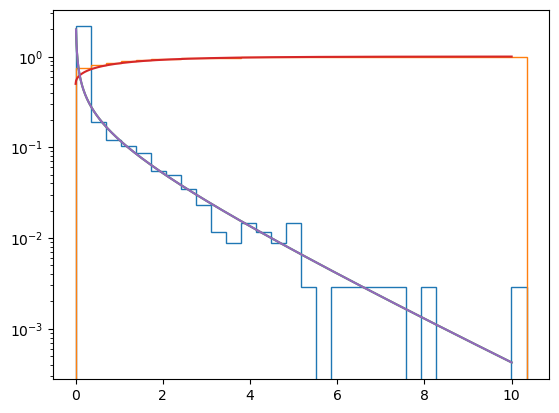

In [260]:
plt.hist(np.array(rvs1000).ravel(), bins=30, histtype='step', density=True)
plt.hist(np.array(rvs1000).ravel(), bins=30, histtype='step', density=True, cumulative=True)

q_plot = QMuTestStatistic(asi_dataset, 'scale') 
plt.plot(np.linspace(0,10, 1000), [q_plot.asympotic_approximation_pdf(x, 1, 1) for x in np.linspace(0,10, 1000)])
plt.plot(np.linspace(0,10, 1000), [q_plot.asympotic_approximation_cdf(x, 1, 1) for x in np.linspace(0,10, 1000)])
plt.plot(np.linspace(0,10, 1000), 0.5*chi2(df=1).pdf(np.linspace(0,10, 1000)))
plt.yscale('log')

In [375]:
from titrate.statistics import kstest

In [380]:
kstest(np.array(rvs1000).ravel(), lambda x: q_plot.asympotic_approximation_cdf(x, 1, 1))

0.3868858273680682

In [410]:
validator = AsymptoticValidator(meas_dataset, asi_dataset, 'qmu', 'scale')

In [422]:
validator.validate(n_toys=100)

{'pvalue_diff': 0.9723793073618595,
 'pvalue_same': 0.9702833449616224,
 'valid': True}

/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:105: RuntimeWarning: divide by zero encountered in divide
  1


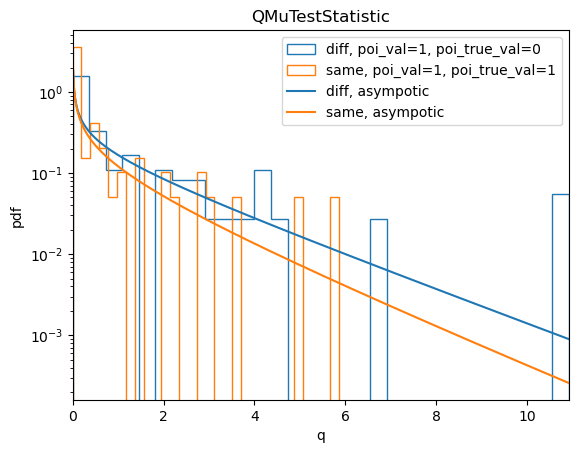

In [423]:
validator.plot_validation(n_toys=100)

In [424]:
validator = AsymptoticValidator(meas_dataset, asi_dataset, 'qtildemu', 'scale')

In [447]:
timeit validator.validate(n_toys=100)

/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:229: RuntimeWarning: invalid value encountered in sqrt
  ), norm.cdf(np.sqrt(ts_val) - (poi_val - poi_true_val) / sigma))
/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:229: RuntimeWarning: invalid value encountered in sqrt
  ), norm.cdf(np.sqrt(ts_val) - (poi_val - poi_true_val) / sigma))
/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:229: RuntimeWarning: invalid value encountered in sqrt
  ), norm.cdf(np.sqrt(ts_val) - (poi_val - poi_true_val) / sigma))
/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:229: RuntimeWarning: invalid value encountered in sqrt
  ), norm.cdf(np.sqrt(ts_val) - (poi_val - poi_true_val) / sigma))
/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:229: RuntimeWarning: invalid value encountered in sqrt
  ), norm.cdf(np.sqrt(ts_val) - (poi_val - poi_true_val) / sigma))
/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:229: Runtime

874 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:229: RuntimeWarning: invalid value encountered in sqrt
  ), norm.cdf(np.sqrt(ts_val) - (poi_val - poi_true_val) / sigma))


In [ ]:
timeit validator.validate(n_toys=10)

/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:210: RuntimeWarning: divide by zero encountered in divide
  1


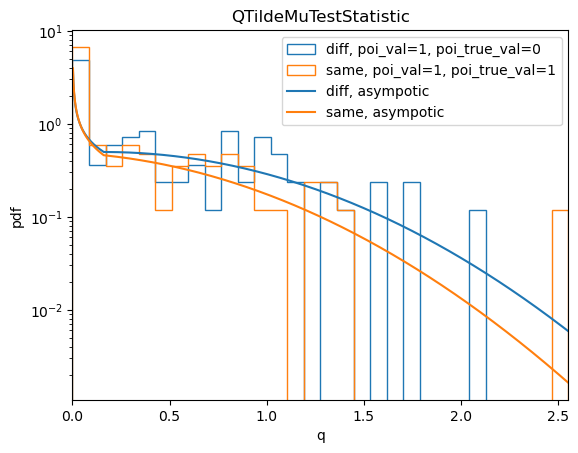

In [448]:
validator.plot_validation(n_toys=100)